3. a

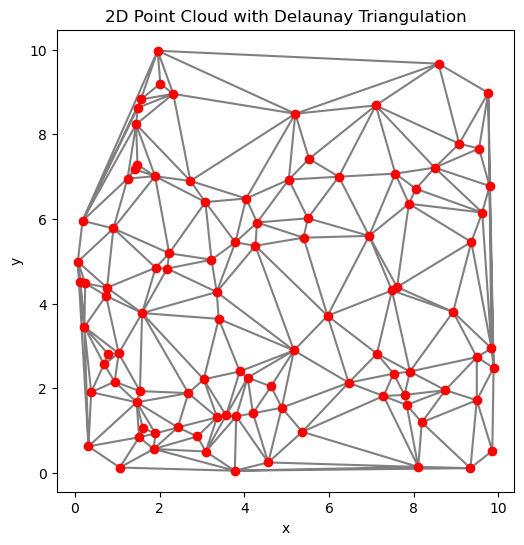

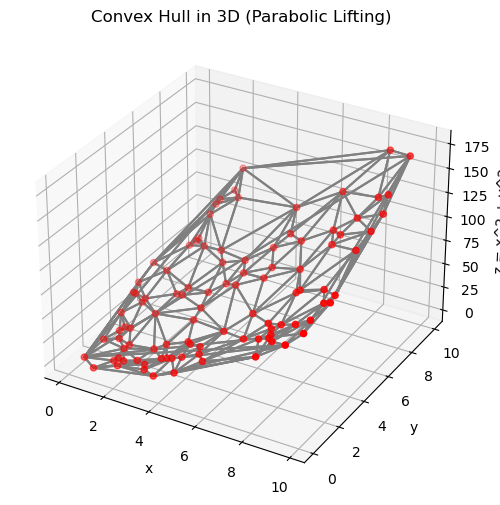

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay, ConvexHull

points_2d = np.loadtxt("mesh.dat", skiprows=1)

# 2) Delaunay triangulation in 2D
tri_2d = Delaunay(points_2d)

# 3) Plot the 2D points + Delaunay triangulation
plt.figure(figsize=(6,6))
plt.triplot(points_2d[:,0], points_2d[:,1], tri_2d.simplices, color='gray')
plt.scatter(points_2d[:,0], points_2d[:,1], c='red')
plt.title("2D Point Cloud with Delaunay Triangulation")
plt.xlabel("x")
plt.ylabel("y")
plt.gca().set_aspect('equal', 'box')
plt.show()

# 4) Parabolic lifting: (x, y) -> (x, y, x^2 + y^2)
points_3d = np.column_stack([
    points_2d[:,0],
    points_2d[:,1],
    points_2d[:,0]**2 + points_2d[:,1]**2
])

# 5) Compute convex hull of the lifted points
hull_3d = ConvexHull(points_3d)

# 6) Plot the convex hull in 3D
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(projection='3d')
ax.scatter(points_3d[:,0], points_3d[:,1], points_3d[:,2], c='red')

# Draw the hull facets
for simplex in hull_3d.simplices:
    hull_vertices = points_3d[simplex]
    # Close the triangle
    hull_vertices = np.vstack([hull_vertices, hull_vertices[0]])
    ax.plot(hull_vertices[:,0], hull_vertices[:,1], hull_vertices[:,2], 'gray')

ax.set_title("Convex Hull in 3D (Parabolic Lifting)")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z = x^2 + y^2")
plt.show()

3. b

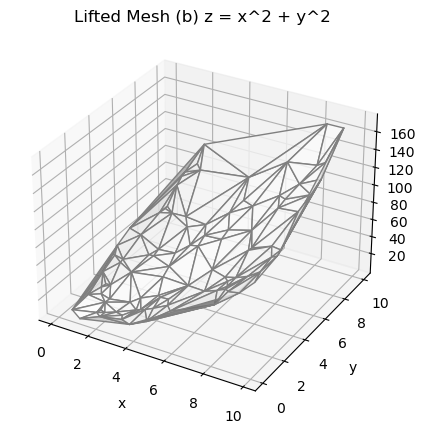

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import Delaunay

points_2d = np.loadtxt("mesh.dat", skiprows=1)

def lift_3d(x, y):
    return np.array([x, y, x**2 + y**2])

lifted_points = np.array([lift_3d(px, py) for (px, py) in points_2d])

tri = Delaunay(points_2d)

fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')
ax.set_title("Lifted Mesh (b) z = x^2 + y^2")
ax.plot_trisurf(
    lifted_points[:,0],
    lifted_points[:,1],
    lifted_points[:,2],
    triangles=tri.simplices,
    color='white',
    edgecolor='gray',
    alpha=0.8
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()


3. c

In [3]:
def calculate_induced_metric(x, y):
    E = 1 + 4 * x**2
    F = 4 * x * y
    G = 1 + 4 * y**2
    return np.array([[E, F], [F, G]])

x, y = 1.0, 1.0
metric = calculate_induced_metric(x, y)
print("Induced Metric at (x, y) = (1.0, 1.0):")

print(metric)

Induced Metric at (x, y) = (1.0, 1.0):
[[5. 4.]
 [4. 5.]]


3. d

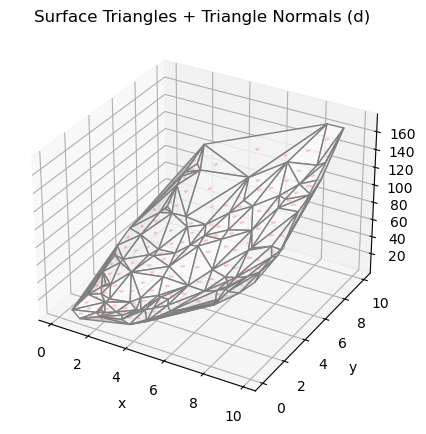

In [4]:
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')
ax.set_title("Surface Triangles + Triangle Normals (d)")

# Plot the mesh
ax.plot_trisurf(
    lifted_points[:,0],
    lifted_points[:,1],
    lifted_points[:,2],
    triangles=tri.simplices,
    color='white',
    edgecolor='gray',
    alpha=0.8
)

# For each triangle, compute the normal and plot
for simplex in tri.simplices:
    p1, p2, p3 = lifted_points[simplex]
    v1 = p2 - p1
    v2 = p3 - p1
    tri_normal = np.cross(v1, v2)
    norm_len = np.linalg.norm(tri_normal)
    if norm_len < 1e-14:
        continue
    tri_normal /= norm_len
    centroid = (p1 + p2 + p3)/3
    ax.quiver(
        centroid[0], centroid[1], centroid[2],
        tri_normal[0], tri_normal[1], tri_normal[2],
        length=0.2, color='red'
    )

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()


3. e

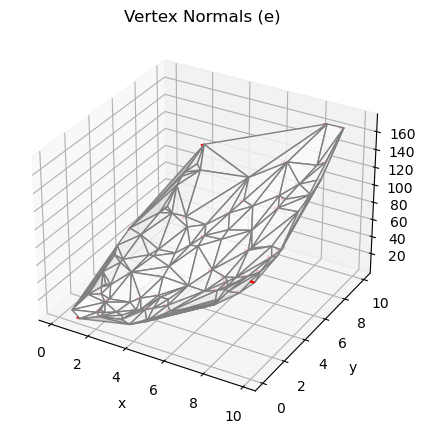

In [5]:
vertex_normals = np.zeros_like(lifted_points)

for simplex in tri.simplices:
    p1, p2, p3 = lifted_points[simplex]
    v1 = p2 - p1
    v2 = p3 - p1
    tri_normal = np.cross(v1, v2)
    for idx in simplex:
        vertex_normals[idx] += tri_normal

# Normalize
for i in range(len(vertex_normals)):
    length = np.linalg.norm(vertex_normals[i])
    if length > 1e-14:
        vertex_normals[i] /= length

fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')
ax.set_title("Vertex Normals (e)")

ax.plot_trisurf(
    lifted_points[:,0],
    lifted_points[:,1],
    lifted_points[:,2],
    triangles=tri.simplices,
    color='white',
    edgecolor='gray',
    alpha=0.8
)

for i, p in enumerate(lifted_points):
    n = vertex_normals[i]
    ax.quiver(
        p[0], p[1], p[2],
        n[0], n[1], n[2],
        length=0.2, color='red'
    )

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()

3. f

In [6]:
def partial_derivatives(x, y):
    dx = np.array([1, 0, 2 * x])
    dy = np.array([0, 1, 2 * y])
    return dx, dy

def second_partial_derivatives(x, y):
    dxx = np.array([0, 0, 2])
    dyy = np.array([0, 0, 2])
    dxy = np.array([0, 0, 0])
    return dxx, dyy, dxy

second_fundamental_forms = []
for i, vertex in enumerate(lifted_points):
    dx, dy = partial_derivatives(vertex[0], vertex[1])
    dxx, dyy, dxy = second_partial_derivatives(vertex[0], vertex[1])
    normal = vertex_normals[i]
    second_fundamental = np.array([
        
        [np.dot(dxx, normal), np.dot(dxy, normal)],
        [np.dot(dxy, normal), np.dot(dyy, normal)]
    ])
    second_fundamental_forms.append(second_fundamental)
second_fundamental_forms


[array([[0.1005733, 0.       ],
        [0.       , 0.1005733]]),
 array([[0.10755526, 0.        ],
        [0.        , 0.10755526]]),
 array([[0.23245071, 0.        ],
        [0.        , 0.23245071]]),
 array([[0.07507263, 0.        ],
        [0.        , 0.07507263]]),
 array([[0.26356673, 0.        ],
        [0.        , 0.26356673]]),
 array([[0.16976655, 0.        ],
        [0.        , 0.16976655]]),
 array([[0.16627746, 0.        ],
        [0.        , 0.16627746]]),
 array([[0.12149473, 0.        ],
        [0.        , 0.12149473]]),
 array([[0.149772, 0.      ],
        [0.      , 0.149772]]),
 array([[0.07754653, 0.        ],
        [0.        , 0.07754653]]),
 array([[0.09771708, 0.        ],
        [0.        , 0.09771708]]),
 array([[0.09522691, 0.        ],
        [0.        , 0.09522691]]),
 array([[0.08857892, 0.        ],
        [0.        , 0.08857892]]),
 array([[0.13398516, 0.        ],
        [0.        , 0.13398516]]),
 array([[0.20891953, 0.        ]

3. g

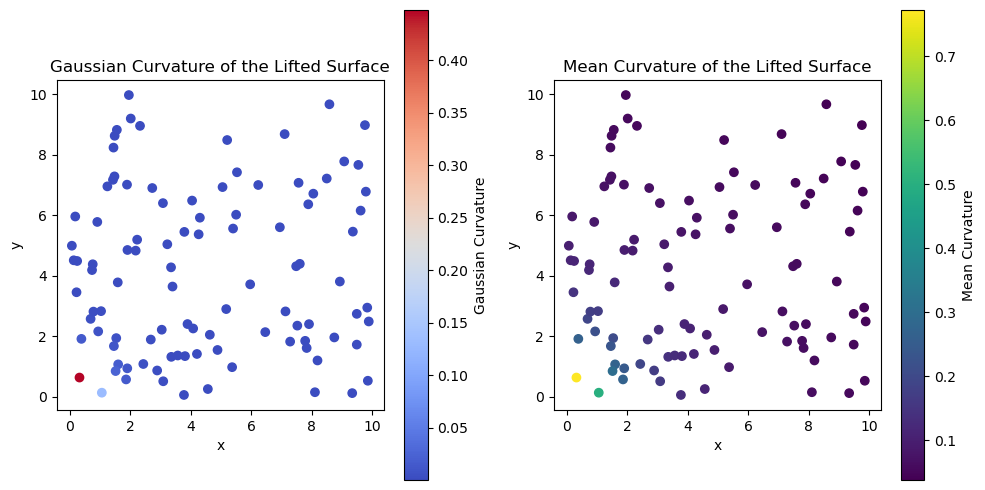

In [7]:
import numpy as np
import matplotlib.pyplot as plt

points_2d = np.loadtxt("mesh.dat", skiprows=1)  
K_vals = np.zeros(len(points_2d))  # Gaussian
H_vals = np.zeros(len(points_2d))  # Mean

def Phi_x(x, y):  return np.array([1.0, 0.0, 2.0*x])
def Phi_y(x, y):  return np.array([0.0, 1.0, 2.0*y])
def Phi_xx(x, y): return np.array([0.0, 0.0, 2.0])
def Phi_xy(x, y): return np.array([0.0, 0.0, 0.0])
def Phi_yy(x, y): return np.array([0.0, 0.0, 2.0])

def unit_normal(x, y):
    cross = np.cross(Phi_x(x, y), Phi_y(x, y))
    norm = np.linalg.norm(cross)
    return cross / norm if norm > 1e-14 else cross

def first_fundamental_form(x, y):
    Ex = Phi_x(x, y)
    Ey = Phi_y(x, y)
    E = np.dot(Ex, Ex)
    F = np.dot(Ex, Ey)
    G = np.dot(Ey, Ey)
    return np.array([[E, F],
                     [F, G]])

def second_fundamental_form(x, y):
    L   = np.dot(Phi_xx(x, y), unit_normal(x, y))
    M   = np.dot(Phi_xy(x, y), unit_normal(x, y))
    N_2 = np.dot(Phi_yy(x, y), unit_normal(x, y))
    return np.array([[L,  M],
                     [M, N_2]])

for i, (x_val, y_val) in enumerate(points_2d):
    I  = first_fundamental_form(x_val, y_val)
    II = second_fundamental_form(x_val, y_val)
    try:
        I_inv = np.linalg.inv(I)
        S = I_inv @ II  # shape operator
        eigvals = np.linalg.eigvals(S)
        k1, k2 = eigvals[0], eigvals[1]
        K_vals[i] = k1 * k2          # Gaussian curvature
        H_vals[i] = 0.5 * (k1 + k2)  # Mean curvature
    except np.linalg.LinAlgError:
        K_vals[i] = 0.0
        H_vals[i] = 0.0

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

# Gaussian
sc1 = ax1.scatter(points_2d[:,0], points_2d[:,1], c=K_vals, cmap='coolwarm')
cb1 = plt.colorbar(sc1, ax=ax1)
cb1.set_label("Gaussian Curvature")
ax1.set_title("Gaussian Curvature of the Lifted Surface")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_aspect("equal", "box")

# Mean
sc2 = ax2.scatter(points_2d[:,0], points_2d[:,1], c=H_vals, cmap='viridis')
cb2 = plt.colorbar(sc2, ax=ax2)
cb2.set_label("Mean Curvature")
ax2.set_title("Mean Curvature of the Lifted Surface")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_aspect("equal", "box")

plt.tight_layout()
plt.show()


3. h

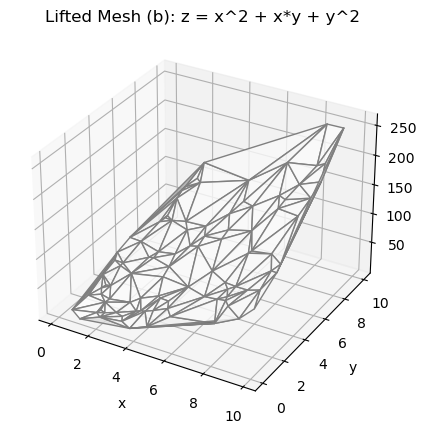

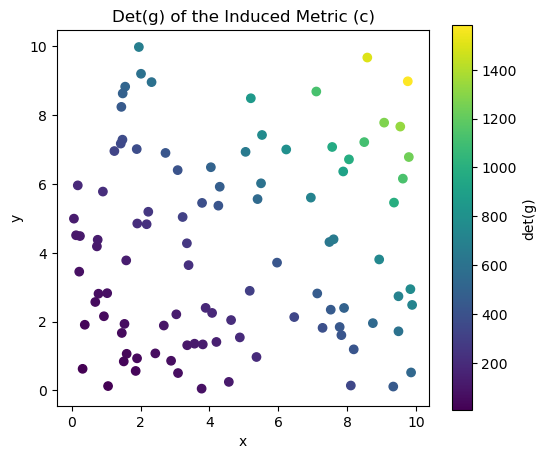

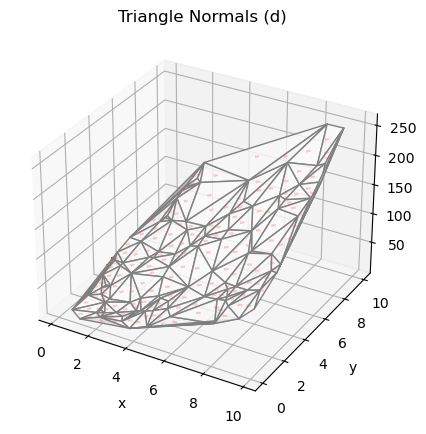

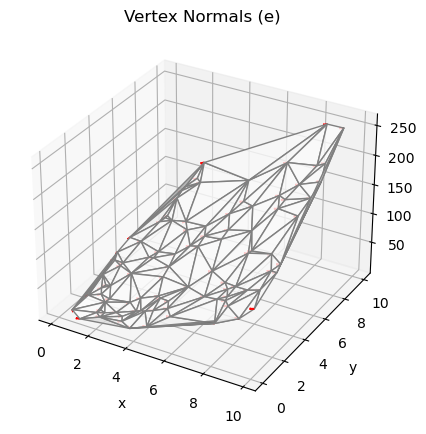

[[[0.06810335 0.03405168]
  [0.03405168 0.06810335]]

 [[0.08043522 0.04021761]
  [0.04021761 0.08043522]]

 [[0.19799451 0.09899726]
  [0.09899726 0.19799451]]

 [[0.05368721 0.02684361]
  [0.02684361 0.05368721]]

 [[0.20441799 0.10220899]
  [0.10220899 0.20441799]]

 [[0.20124481 0.1006224 ]
  [0.1006224  0.20124481]]

 [[0.11482935 0.05741467]
  [0.05741467 0.11482935]]

 [[0.09322476 0.04661238]
  [0.04661238 0.09322476]]

 [[0.10513522 0.05256761]
  [0.05256761 0.10513522]]

 [[0.07139518 0.03569759]
  [0.03569759 0.07139518]]

 [[0.06565758 0.03282879]
  [0.03282879 0.06565758]]

 [[0.06665714 0.03332857]
  [0.03332857 0.06665714]]

 [[0.05939439 0.02969719]
  [0.02969719 0.05939439]]

 [[0.08760027 0.04380014]
  [0.04380014 0.08760027]]

 [[0.26659046 0.13329523]
  [0.13329523 0.26659046]]

 [[0.14838724 0.07419362]
  [0.07419362 0.14838724]]

 [[0.29832961 0.1491648 ]
  [0.1491648  0.29832961]]

 [[0.2024054  0.1012027 ]
  [0.1012027  0.2024054 ]]

 [[0.30747498 0.15373749]
  

TypeError: second_fundamental_form() takes 2 positional arguments but 3 were given

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import Delaunay

##############################################
# 1) LOAD 2D POINTS FROM mesh.dat
##############################################
# If there's a header line like "X Y", use skiprows=1; else skiprows=0.
points_2d = np.loadtxt("mesh.dat", skiprows=1)

##############################################
# LIFTING MAP: z = x^2 + x*y + y^2
##############################################
def lift_map(x, y):
    return np.array([x, y, x*x + x*y + y*y])

lifted_points = np.array([lift_map(px, py) for (px, py) in points_2d])

##############################################
# BUILD A DELAUNAY MESH IN 2D
##############################################
tri = Delaunay(points_2d)

##############################################
# (b) 3D PLOT OF THE LIFTED MESH
##############################################
fig_b = plt.figure(figsize=(6,5))
ax_b = fig_b.add_subplot(111, projection='3d')
ax_b.set_title("Lifted Mesh (b): z = x^2 + x*y + y^2")

ax_b.plot_trisurf(
    lifted_points[:,0],
    lifted_points[:,1],
    lifted_points[:,2],
    triangles=tri.simplices,
    color='white',
    edgecolor='gray',
    alpha=0.8
)
ax_b.set_xlabel("x")
ax_b.set_ylabel("y")
ax_b.set_zlabel("z")
plt.show()

##############################################
# HELPER FUNCTIONS: PARTIAL DERIVATIVES
# Phi(x,y) = (x, y, x^2 + x*y + y^2)
##############################################
def Phi_x(x, y):
    # d/dx => (1, 0, 2x + y)
    return np.array([1.0, 0.0, 2.0*x + y])

def Phi_y(x, y):
    # d/dy => (0, 1, x + 2y)
    return np.array([0.0, 1.0, x + 2.0*y])

def Phi_xx(x, y):
    # d^2/dx^2 => (0, 0, 2)
    return np.array([0.0, 0.0, 2.0])

def Phi_xy(x, y):
    # d^2/dx dy => (0, 0, 1)
    return np.array([0.0, 0.0, 1.0])

def Phi_yy(x, y):
    # d^2/dy^2 => (0, 0, 2)
    return np.array([0.0, 0.0, 2.0])

##############################################
# (c) FIRST FUNDAMENTAL FORM (INDUCED METRIC)
##############################################
def first_fundamental_form(x, y):
    # g_xx = <Phi_x, Phi_x>, g_xy = <Phi_x, Phi_y>, g_yy = <Phi_y, Phi_y>
    Px = Phi_x(x, y)
    Py = Phi_y(x, y)
    E = np.dot(Px, Px)
    F = np.dot(Px, Py)
    G = np.dot(Py, Py)
    return np.array([[E, F],
                     [F, G]])

# Visualize det(g)
g_dets = np.zeros(len(points_2d))
for i, (px, py) in enumerate(points_2d):
    g = first_fundamental_form(px, py)
    g_dets[i] = np.linalg.det(g)

fig_c = plt.figure(figsize=(6,5))
ax_c = fig_c.add_subplot(111)
sc_c = ax_c.scatter(points_2d[:,0], points_2d[:,1], c=g_dets, cmap='viridis')
plt.colorbar(sc_c, ax=ax_c, label="det(g)")
ax_c.set_title("Det(g) of the Induced Metric (c)")
ax_c.set_xlabel("x")
ax_c.set_ylabel("y")
ax_c.set_aspect("equal", "box")
plt.show()

##############################################
# (d) TRIANGLE NORMALS
##############################################
fig_d = plt.figure(figsize=(6,5))
ax_d = fig_d.add_subplot(111, projection='3d')
ax_d.set_title("Triangle Normals (d)")

ax_d.plot_trisurf(
    lifted_points[:,0],
    lifted_points[:,1],
    lifted_points[:,2],
    triangles=tri.simplices,
    color='white',
    edgecolor='gray',
    alpha=0.8
)

for simplex in tri.simplices:
    p1, p2, p3 = lifted_points[simplex]
    v1 = p2 - p1
    v2 = p3 - p1
    tri_normal = np.cross(v1, v2)
    norm_len = np.linalg.norm(tri_normal)
    if norm_len < 1e-14:
        continue
    tri_normal /= norm_len
    centroid = (p1 + p2 + p3)/3
    ax_d.quiver(
        centroid[0], centroid[1], centroid[2],
        tri_normal[0], tri_normal[1], tri_normal[2],
        length=0.2, color='red'
    )

ax_d.set_xlabel("x")
ax_d.set_ylabel("y")
ax_d.set_zlabel("z")
plt.show()

##############################################
# (e) VERTEX NORMALS (by summing triangle normals)
##############################################
vertex_normals = np.zeros_like(lifted_points)
for simplex in tri.simplices:
    p1, p2, p3 = lifted_points[simplex]
    v1 = p2 - p1
    v2 = p3 - p1
    tri_normal = np.cross(v1, v2)
    for idx in simplex:
        vertex_normals[idx] += tri_normal

# Normalize
for i in range(len(vertex_normals)):
    length = np.linalg.norm(vertex_normals[i])
    if length > 1e-14:
        vertex_normals[i] /= length

fig_e = plt.figure(figsize=(6,5))
ax_e = fig_e.add_subplot(111, projection='3d')
ax_e.set_title("Vertex Normals (e)")

ax_e.plot_trisurf(
    lifted_points[:,0],
    lifted_points[:,1],
    lifted_points[:,2],
    triangles=tri.simplices,
    color='white',
    edgecolor='gray',
    alpha=0.8
)
for i, p in enumerate(lifted_points):
    n = vertex_normals[i]
    ax_e.quiver(
        p[0], p[1], p[2],
        n[0], n[1], n[2],
        length=0.2, color='red'
    )

ax_e.set_xlabel("x")
ax_e.set_ylabel("y")
ax_e.set_zlabel("z")
plt.show()

# (f) 
def surface(x, y):
    return x**2 + x * y + y**2

def partial_derivatives(x, y):
    dx = np.array([1, 0, 2 * x + y])  # ∂surface/∂x
    dy = np.array([0, 1, 2 * y + x])  # ∂surface/∂y
    return dx, dy

def second_partial_derivatives(x, y):
    dxx = np.array([0, 0, 2])  # ∂²surface/∂x²
    dyy = np.array([0, 0, 2])  # ∂²surface/∂y²
    dxy = np.array([0, 0, 1])  # ∂²surface/∂x∂y
    return dxx, dyy, dxy

second_fundamental_forms = []
for i, vertex in enumerate(lifted_points):  # `lifted_points` contains [x, y, z] for each point
    x, y = vertex[0], vertex[1]  # Extract x and y coordinates of the vertex
    dx, dy = partial_derivatives(x, y)  # First derivatives from `surface()`
    dxx, dyy, dxy = second_partial_derivatives(x, y)  # Second derivatives
    normal = vertex_normals[i]  # Normals computed in Part (e)

    second_fundamental = np.array([
        [np.dot(dxx, normal), np.dot(dxy, normal)],  # L and M components
        [np.dot(dxy, normal), np.dot(dyy, normal)]   # M and N components
    ])
    second_fundamental_forms.append(second_fundamental)

# Convert to NumPy array for further processing
second_fundamental_forms = np.array(second_fundamental_forms)

print(second_fundamental_forms)  # Print first 3 second fundamental forms

# (g) 
K_vals = np.zeros(len(points_2d))  # Gaussian
H_vals = np.zeros(len(points_2d))  # Mean

for i, (px, py, pz) in enumerate(lifted_points):
    g = first_fundamental_form(px, py)
    II = second_fundamental_form(px, py, vertex_normals[i])
    try:
        g_inv = np.linalg.inv(g)
        S = g_inv @ II
        eigvals = np.linalg.eigvals(S)
        k1, k2 = eigvals[0], eigvals[1]
        K_vals[i] = k1 * k2
        H_vals[i] = 0.5*(k1 + k2)
    except np.linalg.LinAlgError:
        # degenerate
        K_vals[i] = 0.0
        H_vals[i] = 0.0

fig_g, (ax_g1, ax_g2) = plt.subplots(1,2, figsize=(10,5))

sc_g1 = ax_g1.scatter(points_2d[:,0], points_2d[:,1], c=K_vals, cmap='RdBu')
cb_g1 = plt.colorbar(sc_g1, ax=ax_g1)
cb_g1.set_label("Gaussian Curvature")
ax_g1.set_title("Gaussian Curvature (g)")
ax_g1.set_xlabel("x")
ax_g1.set_ylabel("y")
ax_g1.set_aspect("equal", "box")

sc_g2 = ax_g2.scatter(points_2d[:,0], points_2d[:,1], c=H_vals, cmap='viridis')
cb_g2 = plt.colorbar(sc_g2, ax=ax_g2)
cb_g2.set_label("Mean Curvature")
ax_g2.set_title("Mean Curvature (g)")
ax_g2.set_xlabel("x")
ax_g2.set_ylabel("y")
ax_g2.set_aspect("equal", "box")

plt.tight_layout()
plt.show()